In [1]:
import pickle
with open('addons/imr90/coop_matrix_all_new_spaced_3.pkl', 'rb') as handle:
    values_fresh = pickle.load(handle)

In [2]:
import numpy as np
from scipy.stats import wilcoxon
from scipy.spatial import distance


# def profile_define_cooperative_net_pos_neg(motif1_only, motif2_only, cooop, controls):
    
#     effects = []
#     significance = []
#     max_coop = []
#     #print(len(cooop))
#     for i in range(len(cooop)):
#         n = controls[0]
#         #print((motif2_only[i][0]+motif1_only[i][0]).shape)
#         m2_m2 =  distance.jensenshannon(motif2_only[i][0]+motif1_only[i][0],n,axis=1)
#         m1_m2_coop = distance.jensenshannon(cooop[i][0],n,axis=1)
        
#         max_coop.append(m1_m2_coop)
        
        
#         Z = np.squeeze(m1_m2_coop - m2_m2)
        
#         res = wilcoxon(Z)
#         statistic = res.statistic
#         pvalue = res.pvalue
#         effects.append(np.mean(Z/m2_m2))
#         significance.append(pvalue)
        
    
#     #print(len(effects))
   
#     #idx = np.argmin(np.abs(significance))
#     idx = np.argmax(np.abs(effects))
#     nmin=np.max([np.log(motif1_only[idx][1]),np.log(motif2_only[idx][1])], axis=0)
#     nmax=np.log(motif1_only[idx][1])+np.log(motif2_only[idx][1])
#     zscore = np.mean((max_coop[idx]-nmin)/(nmax-nmin))
#     #print(idx)
#     return effects[idx], significance[idx]

def define_cooperative_net_pos_neg(motif1_only, motif2_only, cooop, controls, dists):
    
    effects = []
    significance = []
    max_coop = []
    stats = []
    zscores = []
    #print(len(cooop))
    for i in range(len(cooop)):
        n = np.log(controls[1])
        m1 = np.log(motif1_only[i][1])
        m2 = np.log(motif2_only[i][1])
        m1_m2 = np.log(cooop[i][1])
        max_coop.append(m1_m2)
        Y =  m1_m2-n
        
        
        
        Z = np.squeeze(Y - m1 - m2 + 2*n)
    
        
        
        res = wilcoxon(Z)
        statistic = res.statistic
        pvalue = res.pvalue
        effects.append(np.mean(Z))
        significance.append(pvalue)
        stats.append(statistic)
        
        nmax=np.log(motif1_only[i][1])+np.log(motif2_only[i][1])
        nmin=np.max([np.log(motif1_only[i][1]),np.log(motif2_only[i][1])], axis=0)
        zscore = np.mean((max_coop-nmin)/(nmax-nmin))

    
        zscores.append(zscore)
        
    
    #print(len(effects))
   
    if pvalue > 0.005:
        color = 0
    else:
        if np.mean(Z) > 0:
            color = 1
        else:
            z1 = Y-(m1-m2)
            if np.mean(z1) < 0:
                color=2
            else:
                color=3
                
    idx = np.argmin(np.abs(significance))
    print(dists[idx])
    #idx = np.argmax(np.abs(effects))
    #nmin=np.max([np.log(motif1_only[idx][1]),np.log(motif2_only[idx][1])], axis=0)

    #nmin=np.abs(np.log(motif1_only[idx][1]) - np.log(motif2_only[idx][1]))

    return  zscores[idx], significance[idx], color
    # return effects[idx], significance[idx]

In [3]:
import pandas as pd
annotations = pd.read_csv("addons/imr90/imr90.counts.tomtom.motifs_string.tsv",header=0, sep="\t")


In [4]:
annotations.shape


(30, 24)

In [5]:
import sklearn.cluster
import scipy.cluster.hierarchy
import scipy.stats

def cluster_matrix_indices(matrix, num_clusters):
    """
    Clusters matrix using k-means. Always clusters on the first
    axis. Returns the indices needed to optimally order the matrix
    by clusters.
    """
    if len(matrix) == 1:
        # Don't cluster at all
        return np.array([0])

    num_clusters = min(num_clusters, len(matrix))
    
    # Perform k-means clustering
    kmeans = sklearn.cluster.KMeans(n_clusters=num_clusters)
    cluster_assignments = kmeans.fit_predict(matrix)

    # Perform hierarchical clustering on the cluster centers to determine optimal ordering
    kmeans_centers = kmeans.cluster_centers_
    cluster_order = scipy.cluster.hierarchy.leaves_list(
        scipy.cluster.hierarchy.optimal_leaf_ordering(
            scipy.cluster.hierarchy.linkage(kmeans_centers, method="centroid"), kmeans_centers
        )
    )

    # Order the peaks so that the cluster assignments follow the optimal ordering
    cluster_inds = []
    for cluster_id in cluster_order:
        cluster_inds.append(np.where(cluster_assignments == cluster_id)[0])
    cluster_inds = np.concatenate(cluster_inds)
    return cluster_inds

In [6]:
key="metacluster_0.pattern_0-metacluster_0.pattern_1"
effects=np.zeros((30,30))
coop_matrix_n=np.zeros((30,30))
sig_coop_matrix_n=np.zeros((30,30))

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors


row_names = []

for i in range(annotations.shape[0]):
    row_names.append(annotations.loc[i,"Label"])
    print(row_names[i])
    for j in range(i,annotations.shape[0]):
        label1 = annotations.loc[i,"Pattern"] + "-" + annotations.loc[j,"Pattern"]
        if i!=j:
            print(values_fresh[label1][1])
            controls = values_fresh["control"]
            [motif1_only, motif2_only, data_in_spacings, motif1_only_rev, motif2_only_rev, data_in_spacings_rev, distances] = values_fresh[label1][0]
        
            scores, significance, color = define_cooperative_net_pos_neg(motif1_only, motif2_only, data_in_spacings, controls, distances[0:len(data_in_spacings)])
            print(scores)
            effects[j,i] = scores
            coop_matrix_n[j,i] = color
            sig_coop_matrix_n[j,i] = significance    
        
            scores, significance, color = define_cooperative_net_pos_neg(motif1_only_rev, motif2_only_rev, data_in_spacings_rev, controls, distances[len(data_in_spacings):])
            
            effects[i,j] = scores
            coop_matrix_n[i,j] = color
            print(scores)
            sig_coop_matrix_n[i,j] = significance 
            
            #print(sig_coop_matrix_n[i,j])
            #print(sig_coop_matrix_n[j,i])
        else:
            print(values_fresh[label1][1])
            controls = values_fresh["control"]
            [motif1_only, motif2_only, data_in_spacings, motif1_only_rev, motif2_only_rev, data_in_spacings_rev, distances] = values_fresh[label1][0]
        
            scores, significance, color = define_cooperative_net_pos_neg(motif1_only, motif2_only, data_in_spacings, controls, distances[0:len(data_in_spacings)])
            
            effects[j,i] = scores
            coop_matrix_n[j,i] = color
            print(scores)
            sig_coop_matrix_n[j,i] = significance    
                 
#row_names.append(annotations.loc[annotations.shape[0]-1,"Label"])

            


FOS
FOS-FOS
140
0.18196762
FOS-CTCF
3
0.0013923019
-3
-0.0065987986
FOS-FOXC1
9
0.16509657
-4
0.14837985
FOS-FOSB+JUNB
2
0.20320836
-3
0.18835847
FOS-SP1/KLF
140
0.110894844
-140
0.09156115
FOS-NFIC
4
0.12359366
-4
0.12458827
FOS-CEBPB
5
0.17399046
-120
0.14151916
FOS-NFYB
15
0.015540629
-40
0.019888753
FOS-ELK
140
0.0590968
-9
0.07791498
FOS-LYL1
6
0.14107184
-40
0.15067083
FOS-RUNX
7
0.1064888
-2
0.15912671
FOS-NRF1
140
0.081605375
-140
0.070578404
FOS-ETS1
40
0.15430123
-7
0.14909065
FOS-ATF4
3
0.19425783
-2
0.22091989
FOS-ATF1
3
0.12801886
-120
0.10092766
FOS-TEAD4
3
0.21033971
-11
0.15576266
FOS-IRF1
120
0.10738237
-140
0.11276884
FOS-ZNF76
140
0.07924541
-8
0.014304514
FOS-SIX1
150
0.1065439
-150
0.10162391
FOS-TYY1
1
-0.030540809
-1
-0.031838074
FOS-ARNTL
130
0.12611619
-130
0.114862695
FOS-SRF
6
-0.0024406568
-10
0.0024816745
FOS-IRF4
3
0.113555856
-140
0.06517115
FOS-RFX2
140
0.103546575
-120
0.0997497
FOS-ZBTB33
140
0.06459002
-140
0.056617014
FOS-REST
130
0.082825355
-140
0.

-1
0.19217458
NFYB-SRF
15
0.010866109
-3
0.01379242
NFYB-IRF4
2
0.06594775
-1
0.1078302
NFYB-RFX2
11
0.057361715
-1
0.08488049
NFYB-ZBTB33
5
0.09794528
-11
0.096694045
NFYB-REST
20
0.017596332
-9
0.025819043
NFYB-ZNF76.1
7
0.109477036
-2
0.100678876
NFYB-ZEB1
7
-0.07499586
-4
-0.07416523
NFYB-JUNB
10
0.008046867
-1
0.013623861
NFYB-TBD
1
-0.0012591701
-150
-0.008631859
ELK
ELK-ELK
10
0.1333091
ELK-LYL1
9
0.06849422
-2
0.08600701
ELK-RUNX
6
0.032129493
-13
0.03084168
ELK-NRF1
13
0.16979799
-6
0.14150797
ELK-ETS1
6
0.11903936
-12
0.11481981
ELK-ATF4
11
0.06409741
-14
0.069525994
ELK-ATF1
7
0.096440986
-11
0.0944196
ELK-TEAD4
2
0.06034134
-4
0.055873185
ELK-IRF1
13
0.076732926
-1
0.111283034
ELK-ZNF76
15
0.11504478
-12
0.12942596
ELK-SIX1
13
0.06216824
-2
0.061131705
ELK-TYY1
15
0.12627518
-1
0.1507782
ELK-ARNTL
1
0.20801964
-4
0.19191183
ELK-SRF
15
0.032510135
-3
0.052711673
ELK-IRF4
6
0.1223409
-10
0.12420984
ELK-RFX2
11
0.1203939
-2
0.12883545
ELK-ZBTB33
6
0.16652161
-14
0.17550358
ELK

0.22690897
-8
0.27309117
ARNTL-ZEB1
3
-0.16092066
-15
-0.16199489
ARNTL-JUNB
20
0.058963757
-1
0.07045653
ARNTL-TBD
1
-0.04498507
-150
0.0094277905
SRF
SRF-SRF
13
0.0043370817
SRF-IRF4
2
0.046863146
-1
0.060692262
SRF-RFX2
6
0.037872627
-2
0.045210924
SRF-ZBTB33
1
0.07626418
-11
0.05028993
SRF-REST
40
0.016639033
-2
0.016240126
SRF-ZNF76.1
14
0.06294464
-1
0.082900554
SRF-ZEB1
7
-0.058174737
-15
-0.058143128
SRF-JUNB
20
0.008075189
-6
0.0012319954
SRF-TBD
8
-0.0060262023
-12
-0.007556977
IRF4
IRF4-IRF4
11
0.10828426
IRF4-RFX2
7
0.108492844
-6
0.11657825
IRF4-ZBTB33
5
0.18305038
-11
0.18698645
IRF4-REST
20
0.078478836
-7
0.08611877
IRF4-ZNF76.1
15
0.1536382
-3
0.17981946
IRF4-ZEB1
5
-0.069034554
-2
-0.072268926
IRF4-JUNB
20
0.024351897
-3
0.024301939
IRF4-TBD
2
-0.008747863
-4
0.017365355
RFX2
RFX2-RFX2
120
0.10885855
RFX2-ZBTB33
4
0.17642124
-6
0.16990863
RFX2-REST
120
0.09254218
-15
0.09548326
RFX2-ZNF76.1
14
0.15272422
-4
0.16906235
RFX2-ZEB1
3
-0.10537388
-15
-0.11300767
RFX2-JUNB
1

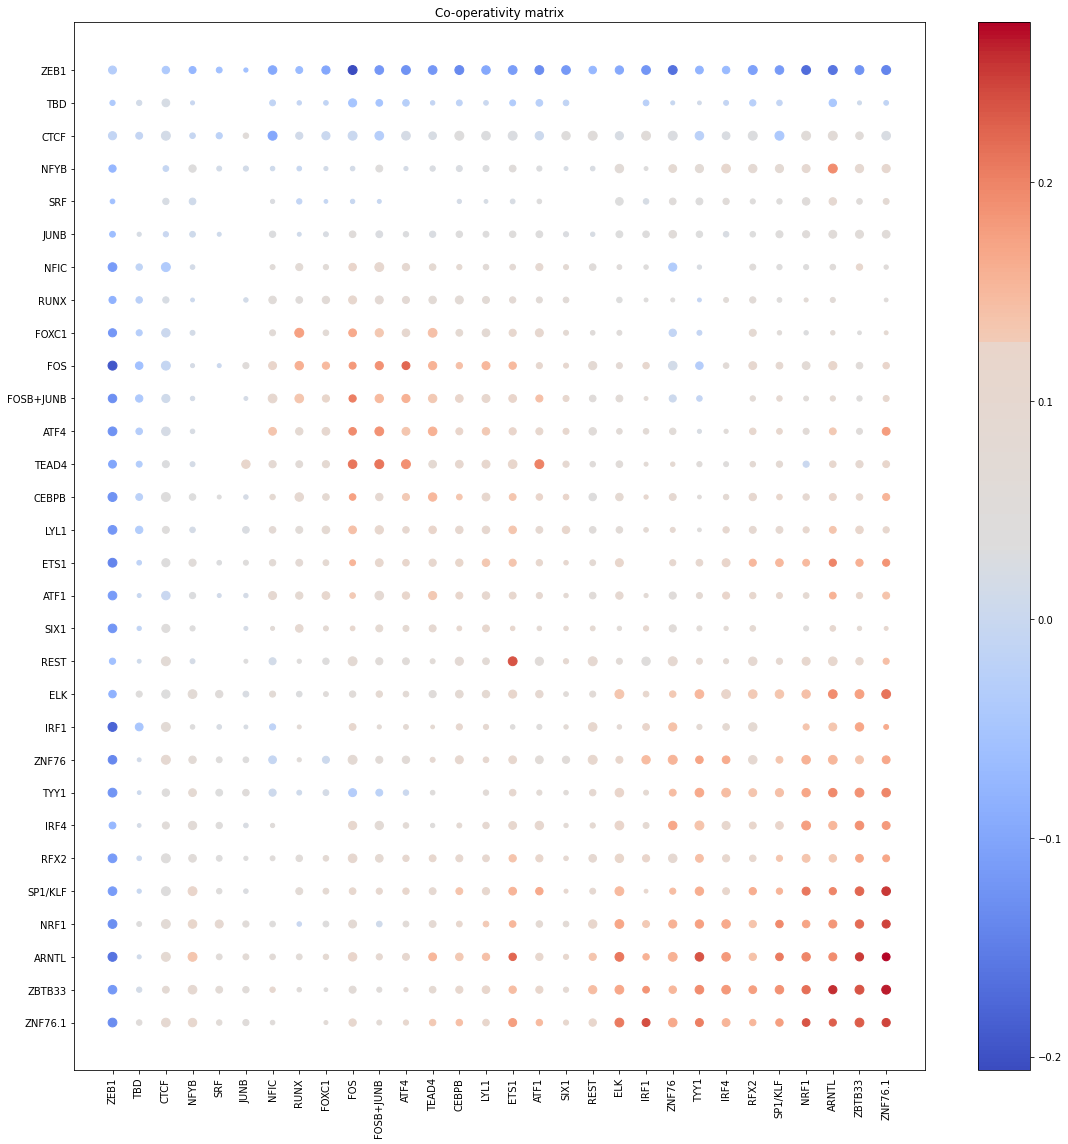

In [7]:
# define the colormap
#cmap = plt.get_cmap('PuOr')
# extract all colors from the .jet map
#cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
#cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)


import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import BoundaryNorm
from matplotlib import colors
# Create a figure with the right dimensions
fig, ax = plt.subplots(figsize=(16, 16))


norm = TwoSlopeNorm(vmin=effects.min(), vcenter=(effects.min()+effects.max())/2, vmax=effects.max())
#inds = cluster_matrix_indices(coop_matrix_n,10)
inds = cluster_matrix_indices(effects,10)

colors_undersea = plt.cm.coolwarm(np.linspace(0, 0.5, 256))
colors_land = plt.cm.coolwarm(np.append(np.linspace(0.5, 0.55, 100),np.linspace(0.6, 1, 256-100)))
all_colors = np.vstack((colors_undersea, colors_land))
terrain_map = colors.LinearSegmentedColormap.from_list(
    'terrain_map', all_colors)

# generate coordinates for the image. Note that the image is "top down", so the y coordinate goes from high to low.
ys, xs = np.mgrid[coop_matrix_n.shape[1]:0:-1,0:coop_matrix_n.shape[1]]

# Scatter plots take 1d arrays of xs and ys, and the colour takes a 2d array,
# with the second dimension being RGB
sizes=np.log(sig_coop_matrix_n[inds][:,inds]+1e-20)*-2
sizes[sizes<(np.log(0.001+1e-20)*-2)]=0
hmap = ax.scatter(xs.flatten(), ys.flatten(), s=sizes,
             c=effects[inds][:,inds], cmap=terrain_map, norm=norm, edgecolor='face')
colors1 = ["#D3D3D3", "red", "blue", "green"]
cmap = colors.ListedColormap(colors1)


int_to_str_mapping= {0:"#D3D3D3", 1:"red", 2:"blue", 3:"green"}
str_2d_array = np.vectorize(int_to_str_mapping.get)(coop_matrix_n)
#hmap = ax.scatter(xs.flatten(), ys.flatten(), s=np.log(sig_coop_matrix_n[inds][:,inds]+1e-20)*-1,
#            c=effects, edgecolor='face')


#np.log(sig_coop_matrix_n[inds][:,inds]+1e-20)*-20
#np.abs(coop_matrix_n[inds][:,inds])*500
# plotting
#hmap = plt.imshow(ls.blend_hsv(z_data_rgb, coop_matrix[inds][:, inds]))


# Set axes on heatmap
ax.set_yticks(np.arange(1,len(row_names)+1))
ax.set_yticklabels(np.array(row_names)[inds][::-1])
ax.set_xticks(np.arange(len(row_names)))
ax.set_xticklabels(np.array(row_names)[inds], rotation=90)

#Loop over data dimensions and create text annotations.
#for i in range(len(row_names)):
#    for j in range(len(row_names)):
#        if np.round(coop_matrix_n[inds][i, j],2) !=0 :
#            ax.text(j, i, np.round(coop_matrix_n[inds][i, j],2), ha="center", va="center")
fig.colorbar(hmap, orientation="vertical")

ax.set_title("Co-operativity matrix")
fig.tight_layout()
    
#plt.savefig("subfigs/motif_cooperativiity_imr90_dotplot.pdf", dpi=300, transparent=True)

plt.show()

In [8]:
np.log(0.005+1e-20)

-5.298317366548036

In [9]:
np.min(sig_coop_matrix_n)

3.896340037647931e-18

In [10]:
np.array(zscores).shape

distance = [-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-20,-40,-50,-60,-70,-80,-90,-100,-110,-120,-130,-140,-150]

distance = distance[::-1]+[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40,50,60,70,80,90,100,110,120,130,140,150]

NameError: name 'zscores' is not defined

In [ ]:
len(distance)

In [ ]:
for key in zscores:
    print(np.array(zscores[key]).shape)

In [ ]:
for key in zscores:
    fig, ax = plt.subplots(figsize=(50, 20))
    inds = cluster_matrix_indices(np.array(zscores[key])[:,:,0],10)
    print(key)
    hmap = ax.imshow(np.array(zscores[key])[inds,:,0], cmap=terrain_map, norm=norm)
    cbar = fig.colorbar(hmap, orientation="vertical")
    ax.set_xticks(np.arange(56))
    ax.set_xticklabels(distance, rotation=90, fontsize=25)
    ax.set_yticks(np.arange(len(rlables[key])))
    ax.set_yticklabels(np.array(rlables[key])[inds], fontsize=25)
    plt.show()
    
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(25)

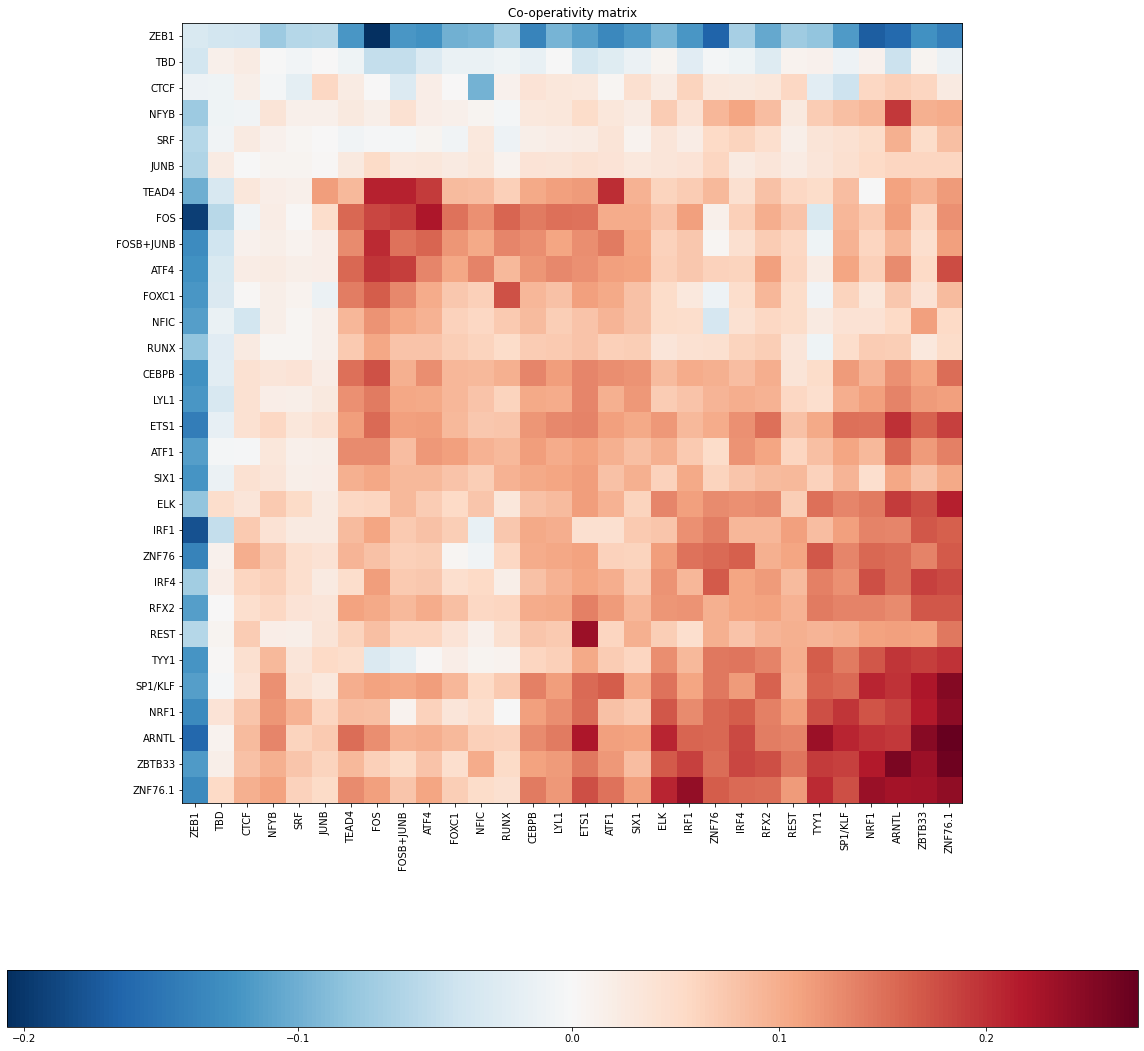

In [12]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# Create a figure with the right dimensions
fig, ax = plt.subplots(figsize=(16, 16))

# define the colormap
#cmap = plt.get_cmap('PuOr')

# extract all colors from the .jet map
#cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
#cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)


norm = TwoSlopeNorm(vmin=effects.min(), vcenter=0, vmax=effects.max())

inds = cluster_matrix_indices(effects,10)

# Plot the heatmap
# defining light source
#ls = mcolors.LightSource()

hmap = ax.imshow(effects[inds][:,inds], norm=norm, cmap="RdBu_r")
#hmap = ax.imshow(coop_matrix)


# plotting
#hmap = plt.imshow(ls.blend_hsv(z_data_rgb, coop_matrix[inds][:, inds]))


# Set axes on heatmap
ax.set_yticks(np.arange(len(row_names)))
ax.set_yticklabels(np.array(row_names)[inds])
ax.set_xticks(np.arange(len(row_names)))
ax.set_xticklabels(np.array(row_names)[inds], rotation=90)

#Loop over data dimensions and create text annotations.
#for i in range(len(row_names)):
#    for j in range(len(row_names)):
#        if np.round(coop_matrix_n[inds][i, j],2) !=0 :
#            ax.text(j, i, np.round(coop_matrix_n[inds][i, j],2), ha="center", va="center")
fig.colorbar(hmap, orientation="horizontal")

ax.set_title("Co-operativity matrix")
fig.tight_layout()

#plt.savefig("subfigs/motif_cooperativiity_imr90_2.pdf", dpi=300, transparent=True)


In [87]:
print(coop_matrix_n.max())

1.0178497509763884


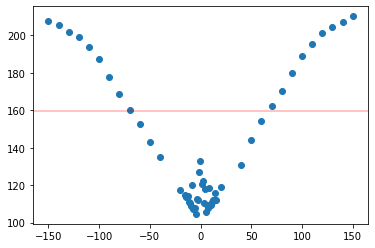

In [81]:
keyd="metacluster_0.pattern_0-metacluster_1.pattern_0"
plt.scatter(values2[keyd][0][3],values2[keyd][0][2])
#plt.axhline(values2[keyd][0]+values2[keyd][1], color="blue", alpha=0.3)
#plt.axhline(values2[keyd][0][0][0], color="green", alpha=0.3)
plt.axhline(np.abs(values2[keyd][0][0][0]-values2[keyd][0][1][0]), color="red", alpha=0.3)
plt.savefig("subfigs/zeb_fos_coord_effect_syntax.pdf", transparent=True, dpi=300)


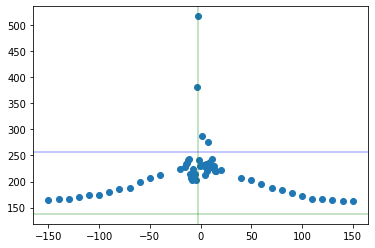

In [79]:
keyd="metacluster_0.pattern_4-metacluster_0.pattern_19"
plt.scatter(values2[keyd][0][3],values2[keyd][0][2])
plt.axhline(values2[keyd][0][0][0]+values2[keyd][0][1][0], color="blue", alpha=0.3)
plt.axhline(values2[keyd][0][0][0], color="green", alpha=0.3)
plt.axvline(-3, color="green", alpha=0.3)

#plt.axhline(np.abs(values2[keyd][0][0][0]-values2[keyd][0][1][0]), color="red", alpha=0.3)


In [77]:
#values2.keys()